In [55]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import numba as nb
import time


In [56]:
IMAGE_PATH = "Image.jpg"

In [57]:
image = np.array(PIL.Image.open(IMAGE_PATH))

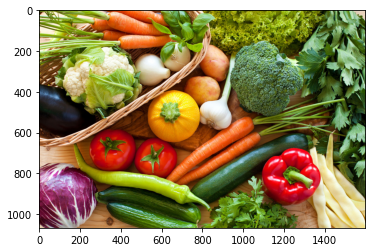

In [58]:
plt.imshow(image)

In [59]:
def get_data(file_path, delim):
    with open(file_path) as f:
        features = np.array(list(map(lambda x : list(map(float, x.strip().split(delim))),f.readlines())))
    return features

In [60]:
data = np.append(get_data("non-linear-data/Class1.txt","\t"), get_data("non-linear-data/Class2.txt","\t"),0)

In [61]:



point_specs = [
    ('cluster', nb.int64),
    ('x', nb.float64),
    ('y', nb.float64),
    ('id', nb.float64)
]

class Point(np.ndarray):
    def __new__(self, *args, **kwargs):
        return super(Point, self).__new__(self, *args, **kwargs)
    def __array_finalize__(self, obj):
        self.cluster = -1
    def set_id(self, id):
        self.id = id
    def set_cordinates(self, x, y):
        self.x = x
        self.y = y

def sample_centroids_initializer(data, k):
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def convert2point(array, id, x=None, y=None):
    array = array.astype(float)
    new = array.view(Point)
    new.set_id(id)
    if x!=None and y!=None:
        new.set_cordinates(x,y)
    return new

def get_points(data):
    new_data = []
    for i, p in enumerate(data):
        new_data.append(convert2point(p, i))
    return new_data

def get_components(data):
    components = [[] for i in range(len(data[0]))]
    for i in data:
        for j in range(len(i)):
            components[j].append(i[j])
    return components

# @nb.njit
def get_mean(model, cluster_id):
    ans = np.zeros(model.input_shape, float)
    if not model.points[cluster_id]:
        return model.centers[cluster_id] 
    for point_id in model.points[cluster_id]:
        ans += model.data[point_id]
    return ans/len(model.points[cluster_id])

# @nb.njit
def resolve_cluster(model, cluster_id : int):
    model.centers[cluster_id] = model.get_mean(cluster_id)
    remove_points = []
    for point_id in model.points[cluster_id]:
        distances = np.zeros(model.k, dtype=float)
        for i, center in enumerate(model.centers):
            distances[i] = model.distance_function(model.data[point_id], center)
        new_cluster = np.argmin(distances)
        if new_cluster == cluster_id:
            continue
        model.union_buffer[new_cluster].add(point_id)
        remove_points.append(point_id)
        model.data[point_id].cluster = new_cluster
    for i in remove_points:
        model.points[cluster_id].remove(i)
    model.centers[cluster_id] = model.get_mean(cluster_id)


kmeans_specs = [
    ('data', list),
    ('union_buffer', set),
    ('centers', np.ndarray),
    ('points',set),
    ('k',int),
    ('input_shape',list),
]

 # @nb.jitclass(kmeans_specs)
class Kmeans:

    def __init__(self, k, input_shape, distance_function=lambda x, y : np.linalg.norm(x-y)):
        # initializing centers using normal distribution
        self.centers = np.random.normal(0., 1., size=(k, input_shape)) 
        self.points = [ set() for i in range(k) ]
        self.distance_function = distance_function
        self.k = k
        self.input_shape = input_shape
        self.data = None
        self.union_buffer = [ set() for i in range(k) ]

    def fit(self, data, iterations=300): # data list of Points
        self.data = data
        for point in data:
            distances = np.zeros(self.k, dtype=float)
            for i, center in enumerate(self.centers):
                distances[i] = self.distance_function(point, center)
            cluster_id = np.argmin(distances)
            self.points[cluster_id].add(point.id)
            self.data[point.id].cluster = cluster_id

        for i in range(iterations):
            s_time = time.time()
            self.union_buffer = [ set() for i in range(self.k) ]
            for cluster_id in range(self.k):
                self.resolve_cluster(cluster_id)
            for cluster_id in range(self.k):
                self.points[cluster_id].union(self.union_buffer[cluster_id])
            e_time = time.time()
            print(f"Iteration {i+1} : {round(e_time-s_time, 2)}")
        

    def resolve_point(self, point: Point):
        distances = np.zeros(self.k, dtype=float)
        for i, center in enumerate(self.centers):
            distances[i] = self.distance_function(point, center)
        new_cluster = np.argmin(distances)
        if point.cluster == new_cluster:
            return
        if point.cluster != -1:
            self.points[point.cluster].remove(point.id)
        self.points[new_cluster].add(point.id)
        point.cluster = new_cluster

    def get_mean(self, cluster_id):
        
        ans = np.zeros(self.input_shape, float)
        if not self.points[cluster_id]:
            return self.centers[cluster_id] 
        for point_id in self.points[cluster_id]:
            ans += self.data[point_id]
        return ans/len(self.points[cluster_id])
        
        # get_mean(self, cluster_id)

    def resolve_cluster(self, cluster_id : int):
        # print(self.get_mean(cluster_id))
        self.centers[cluster_id] = self.get_mean(cluster_id)
        remove_points = []
        for point_id in self.points[cluster_id]:
            distances = np.zeros(self.k, dtype=float)
            for i, center in enumerate(self.centers):
                distances[i] = self.distance_function(self.data[point_id], center)
            new_cluster = np.argmin(distances)
            if new_cluster == cluster_id:
                continue
            self.union_buffer[new_cluster].add(point_id)
            remove_points.append(point_id)
            self.data[point_id].cluster = new_cluster
        for i in remove_points:
            self.points[cluster_id].remove(i)
        self.centers[cluster_id] = self.get_mean(cluster_id)
        # resolve_cluster(self, cluster_id)
        
    def plot_cluster(self, cluster_id):
        for point_id in self.points[cluster_id]:
            plt.scatter(*self.data[point_id])
    
    def plot(self):
        components = get_components(self.data)
        labels = [ i.cluster for i in self.data ]
        plt.scatter(*components, c=labels)
        for i in self.centers:
            plt.scatter(*i,c='black',s=50, marker='x')

        

Iteration 1 : 0.09
Iteration 2 : 0.08
Iteration 3 : 0.06
Iteration 4 : 0.07
Iteration 5 : 0.09
Iteration 6 : 0.08
Iteration 7 : 0.07
Iteration 8 : 0.07
Iteration 9 : 0.07
Iteration 10 : 0.08


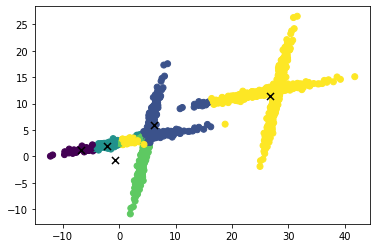

In [62]:
def solve_for_data(data):
    model = Kmeans(5, data.shape[-1])
    model.fit(get_points(data), 10)
    model.plot()
solve_for_data(data)

In [ ]:
def initialize_centroids(data, k):
    centroids = data.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(data, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def move_centroids(data, closest, centroids):
    return np.array([data[closest==k].mean(axis=0) for k in range(centroids.shape[0])])    

def kmeans(data, k, iterations=5, plot_2d=False):
    centroids = initialize_centroids(data, k)
    init_time = time.time()
    for i in range(iterations):
        s_time = time.time()
        cluster = closest_centroid(data, centroids)
        centroids = move_centroids(data, cluster, centroids)
        print(f" iteration {i+1} : {time.time()-s_time}")

    if plot_2d:
        plt.scatter(data[:,0], data[:,1], c=cluster)
        plt.scatter(centroids[:,0], centroids[:,1], c='black', marker='x')
    print(f"total : {time.time()-init_time}")
    return centroids, cluster


def segmented_image(data_shape, centroids, cluster, shape):
    seg_img = np.zeros(data_shape)
    for i in range(seg_img.shape[0]):
        # print(centroids[cluster[i]][:3])
        seg_img[i] = centroids[cluster[i]][:data_shape[-1]]
    seg_img = seg_img.reshape(shape)
    return seg_img


In [113]:
def preprocess1(image):
    x, y, z = image.shape
    data = []
    cnt = 0
    image = image.astype(np.float64)
    image = image/127.5 -1 # normalizing
    for i in range(x):
        for j in range(y):
            data.append(convert2point(image[i][j], cnt,i, j))
            cnt+=1
    return data

def preprocess(image):
    image = image.astype(np.float64)
    image = image/127.5 -1
    return np.array(list(zip(image[:,:,0].flatten(),image[:,:,1].flatten(),image[:,:,0].flatten())))

def preprocess2(image):
    image = image.astype(np.float64)
    image = image/127.5 -1
    xs = []
    ys = [] 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            xs.append(i)
            ys.append(j)
    xs, ys = np.array(xs)/(1067./2) -1, np.array(ys)/800 -1
    return np.array(list(zip(image[:,:,0].flatten(),image[:,:,1].flatten(),image[:,:,0].flatten(), xs, ys)))


 iteration 1 : 0.0007216930389404297
 iteration 2 : 0.0011000633239746094
 iteration 3 : 0.0009748935699462891
 iteration 4 : 0.0007281303405761719
 iteration 5 : 0.0005924701690673828
 iteration 6 : 0.0008339881896972656
 iteration 7 : 0.0008857250213623047
 iteration 8 : 0.0007300376892089844
 iteration 9 : 0.0006458759307861328
 iteration 10 : 0.0008819103240966797
total : 0.02982616424560547


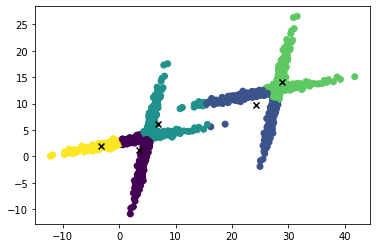

In [72]:
centroids, cluster = kmeans(data,5, 10, True)

In [65]:
img_data = preprocess(image)
img_data.shape

(1707200, 3)

In [94]:
centroids, cluster = kmeans(img_data, 2)

 iteration 1 : 0.1803276538848877
 iteration 2 : 0.17279529571533203
 iteration 3 : 0.18494725227355957
 iteration 4 : 0.17528009414672852
 iteration 5 : 0.18036627769470215
total : 0.8942480087280273


In [67]:
seg_img = segmented_image(img_data.shape, centroids, cluster,image.shape)

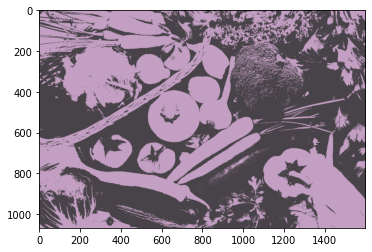

In [68]:
def show_image(seg_img):
    seg_img = (seg_img+1)*127.5
    seg_img = seg_img.astype(np.uint64)
    plt.imshow(seg_img)
show_image(seg_img)

In [106]:
image.shape

(1067, 1600, 3)

In [96]:
img_data2 = preprocess2(image)
img_data2.shape

(1707200, 5)

In [114]:
centroids, cluster = kmeans(img_data2, 3, iterations=20)
seg_img2 = segmented_image(img_data.shape, centroids, cluster,image.shape)

 iteration 1 : 0.3377711772918701
 iteration 2 : 0.28798341751098633
 iteration 3 : 0.3835287094116211
 iteration 4 : 0.5392942428588867
 iteration 5 : 0.534731388092041
 iteration 6 : 0.5430374145507812
 iteration 7 : 0.4969141483306885
 iteration 8 : 0.2668576240539551
 iteration 9 : 0.27169084548950195
 iteration 10 : 0.2771892547607422
 iteration 11 : 0.2662527561187744
 iteration 12 : 0.27055978775024414
 iteration 13 : 0.2689814567565918
 iteration 14 : 0.2613804340362549
 iteration 15 : 0.27520751953125
 iteration 16 : 0.47270941734313965
 iteration 17 : 0.5333137512207031
 iteration 18 : 0.542769193649292
 iteration 19 : 0.5850181579589844
 iteration 20 : 0.6225109100341797
total : 8.041325807571411


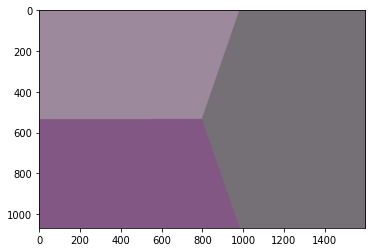

In [115]:
show_image(seg_img2)


In [116]:
centroids

array([[ 2.99199036e-02, -3.12739528e-01,  2.99199036e-02,
         8.09104821e+02,  4.45853721e+02],
       [ 2.25771712e-01,  7.90887179e-02,  2.25771712e-01,
         2.57109438e+02,  4.45194014e+02],
       [-7.66906840e-02, -1.18778885e-01, -7.66906840e-02,
         5.32851191e+02,  1.24191825e+03]])